In [1]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql import types as T

In [2]:
spark = SparkSession.builder.master("local")\
        .appName("Spark")\
        .getOrCreate()

22/05/28 17:18:21 WARN Utils: Your hostname, funny resolves to a loopback address: 127.0.1.1; using 192.168.20.179 instead (on interface wlo1)
22/05/28 17:18:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/28 17:18:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/28 17:18:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# 1. FPGrowth cho tập dữ liệu order.csv và products.csv

## Mô tả dữ liệu : 
Tập dữ liệu order chứa các giao dịch được thực hiện gồm các trường thông tin :
- order_id : mã giao dịch
- product_id : mã sản phẩm
- add_to_cart_order : thứ tự bỏ vào giỏ
- reordered : sản phẩm này có được mua lại không 

Tâp dữ liệu product chứa các sản phẩm bày bán trong cừa hàng gồm các trường thông tin:
- product_id : mã sản phẩm
- product_name : tên sản phẩm 
- và các thông tin khác

**Ta chỉ quan tâm tới 2 trường thuộc tính đầu tiên**

In [3]:
order_data = spark.read.csv('Data/orders.csv',header = True, sep = ',')
order_data.printSchema()
print(order_data.show(5))

root
 |-- order_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- add_to_cart_order: string (nullable = true)
 |-- reordered: string (nullable = true)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows

None


In [4]:
product_data = spark.read.csv('Data/products.csv',header = True, sep = ',')
product_data.printSchema()
print(product_data.show(5))

root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)

+----------+--------------------+--------+-------------+
|product_id|        product_name|aisle_id|department_id|
+----------+--------------------+--------+-------------+
|         1|Chocolate Sandwic...|      61|           19|
|         2|    All-Seasons Salt|     104|           13|
|         3|Robust Golden Uns...|      94|            7|
|         4|Smart Ones Classi...|      38|            1|
|         5|Green Chile Anyti...|       5|           13|
+----------+--------------------+--------+-------------+
only showing top 5 rows

None


## 1.1 Đưa dữ liệu về một DataFrame gồm 2 cột theo đúng thứ tự là `order id`  và danh sách `product_name`

In [5]:
# merge bằng product_id
merge_data = order_data[['order_id','product_id']].\
                        join(product_data[['product_id','product_name']], "product_id")
merge_data.show(10)

+----------+--------+--------------------+
|product_id|order_id|        product_name|
+----------+--------+--------------------+
|     49302|       1|    Bulgarian Yogurt|
|     11109|       1|Organic 4% Milk F...|
|     10246|       1|Organic Celery He...|
|     49683|       1|      Cucumber Kirby|
|     43633|       1|Lightly Smoked Sa...|
|     13176|       1|Bag of Organic Ba...|
|     47209|       1|Organic Hass Avocado|
|     22035|       1|Organic Whole Str...|
|     39612|      36|Grated Pecorino R...|
|     19660|      36|        Spring Water|
+----------+--------+--------------------+
only showing top 10 rows



In [6]:
# thực hiện gom nhóm và ghép giá trị
''' collect_list() function dùng để thu thập lại product_name, 
    những function phía sau chỉ để thay đổi tên cột và chuyển đổi giá trị''' 
data = merge_data.groupby('order_id') \
                 .agg(f.sort_array(f.collect_list(f.struct('product_name'))) \
                                                   .alias("collected_list")) \
                 .withColumn('products',f.col("collected_list.product_name")) \
                 .drop('collected_list').orderBy('order_id')

data.show(5)

+--------+--------------------+
|order_id|            products|
+--------+--------------------+
|       1|[Bag of Organic B...|
|  100000|[Corn Tortillas, ...|
| 1000008|[Daily Moisture S...|
| 1000029|[Almond Chia Gran...|
|  100003|[Cereal, Organic ...|
+--------+--------------------+
only showing top 5 rows



## 1.2 Áp dụng giải thuật FPGrowth.

In [7]:
from pyspark.ml.fpm import FPGrowth

### Case 1 : minSupport = 0.5, minConfidence = 0.75

In [8]:
fpGrowth = FPGrowth(itemsCol='products',
                    minSupport = 0.5, 
                    minConfidence=0.75)

model = fpGrowth.fit(data)
patterns_model1 = model.freqItemsets
rules_model1 = model.associationRules

patterns_model1.show(),rules_model1.show()

/opt/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-----+----+
|items|freq|
+-----+----+
+-----+----+

+----------+----------+----------+----+-------+
|antecedent|consequent|confidence|lift|support|
+----------+----------+----------+----+-------+
+----------+----------+----------+----+-------+



(None, None)

### Nhận xét : 
- Tập dữ liệu khá lớn nên với `minSupport`, `minConfidence` quá lớn ta sẽ khó tìm thấy tập phổ biến và luật
- Giảm `minSupport, minConfidence` nhưng `minConfidence` cũng không quá thấp để đảm bảo độ tin cậy của luật

### Case 2: minSupport = 0.1, minConfidence = 0.5

In [9]:
fpGrowth = FPGrowth(itemsCol='products',
                    minSupport = 0.1, 
                    minConfidence = 0.5)

model = fpGrowth.fit(data)
patterns_model2 = model.freqItemsets
rules_model2 = model.associationRules

patterns_model2.show(),rules_model2.show()

+--------------------+-----+
|               items| freq|
+--------------------+-----+
|[Bag of Organic B...|15480|
|            [Banana]|18726|
+--------------------+-----+

+----------+----------+----------+----+-------+
|antecedent|consequent|confidence|lift|support|
+----------+----------+----------+----+-------+
+----------+----------+----------+----+-------+



(None, None)

### Case 3 : minSupport = 0.005, minConfidence = 0.45

In [10]:
fpGrowth = FPGrowth(itemsCol='products', 
                    minSupport = 0.005,
                    minConfidence = 0.45)

model = fpGrowth.fit(data)
patterns_model3 = model.freqItemsets
rules_model3 = model.associationRules

patterns_model3.show(),rules_model3.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|[Original Orange ...|1054|
|[Total 0% Nonfat ...| 993|
|[Organic Cripps P...| 730|
|[Vine Ripe Tomatoes]| 708|
|      [Green Onions]|1445|
|[Organic Sticks L...|1342|
|[Organic Raw Komb...| 855|
|[Organic Snipped ...| 772|
|[Organic Egg Whites]| 834|
|[Organic Frozen P...| 753|
|[Flat Parsley, Bu...| 658|
|[Medium Navel Ora...| 796|
|[Organic Reduced ...|1535|
|[Natural Spring W...| 950|
|[Organic Baby Rai...| 914|
|[Original Veggie ...| 684|
|     [Organic Basil]|1222|
|[100% Recycled Pa...|1183|
|[Organic Large Br...|1137|
|    [Classic Hummus]| 694|
+--------------------+----+
only showing top 20 rows



+--------------------+--------------------+------------------+-----------------+--------------------+
|          antecedent|          consequent|        confidence|             lift|             support|
+--------------------+--------------------+------------------+-----------------+--------------------+
|[Organic Hass Avo...|[Bag of Organic B...|0.4613385315139701|3.910320890272384|0.005411214169759696|
+--------------------+--------------------+------------------+-----------------+--------------------+



(None, None)

####  Thuật toán đã tìm thấy luật, ta sẽ thử giảm minConfidence

### Case 4 : minSupport = 0.005, minConfidence = 0.3

In [11]:
fpGrowth = FPGrowth(itemsCol='products', 
                    minSupport = 0.005, 
                    minConfidence = 0.3)
model = fpGrowth.fit(data)
patterns_model4 = model.freqItemsets
rules_model4 = model.associationRules

patterns_model4.show(),rules_model4.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|[Original Orange ...|1054|
|[Total 0% Nonfat ...| 993|
|[Organic Cripps P...| 730|
|[Vine Ripe Tomatoes]| 708|
|      [Green Onions]|1445|
|[Organic Sticks L...|1342|
|[Organic Raw Komb...| 855|
|[Organic Snipped ...| 772|
|[Organic Egg Whites]| 834|
|[Organic Frozen P...| 753|
|[Flat Parsley, Bu...| 658|
|[Medium Navel Ora...| 796|
|[Organic Reduced ...|1535|
|[Natural Spring W...| 950|
|[Organic Baby Rai...| 914|
|[Original Veggie ...| 684|
|     [Organic Basil]|1222|
|[100% Recycled Pa...|1183|
|[Organic Large Br...|1137|
|    [Classic Hummus]| 694|
+--------------------+----+
only showing top 20 rows



+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|     [Organic Lemon]|[Bag of Organic B...| 0.3044222539229672| 2.580293250321615| 0.00813206411145577|
|[Organic Hass Avo...|[Bag of Organic B...|0.33182503770739064|2.8125601661853374|0.018443856747631642|
|[Organic Navel Or...|[Bag of Organic B...| 0.3661616161616162| 3.103598158588469|0.005525535595881...|
|    [Cucumber Kirby]|            [Banana]|  0.307915457936179| 2.157496492595755|0.005662721307227...|
|  [Honeycrisp Apple]|            [Banana]|0.34666291185581527|2.4289914558202317|0.009381978370386177|
|       [Blueberries]|            [Banana]|0.30822212656048215| 2.159645252796876| 0.00545694274020837|
|[Organic Large Ex...|[Bag of Organic B...| 0.3365617433414044|2

(None, None)

## 1.3 Nhận xét : 
- Ta thấy ở cột `consequent` mặc định là tập phổ biến chứa `1 item`.
- Vì vậy ta không đảm bảo luật sinh ra theo chiều ngược lại có đúng hay không.
- Để khắc phục vấn đề này ta sẽ xem xét đến tham số `lift`:
    - Tham số  `lift` đánh giá khả năng cùng xuất hiện {A} và {B}
    - Nếu tham số `lift` > 1 và giá trị `lift` càng lớn thì ta có thể xác định chính xác {A} , {B} sẽ cùng xuất hiện 

# 2. Classification cho tập dữ liệu mushroom.csv

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier

## Mô tả dữ liệu : 

### Tập dữ liệu mushroom chứa 8124 mẫu được thể hiện bằng 22 thuộc tính và phân loại  thành `edible`(e) hoặc `poisonous`(p)

In [13]:
mushroom_data = spark.read.csv('Data/mushrooms.csv',header=True,sep = ',')
mushroom_data.printSchema()

root
 |-- class: string (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- bruises: string (nullable = true)
 |-- odor: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-size: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stalk-shape: string (nullable = true)
 |-- stalk-root: string (nullable = true)
 |-- stalk-surface-above-ring: string (nullable = true)
 |-- stalk-surface-below-ring: string (nullable = true)
 |-- stalk-color-above-ring: string (nullable = true)
 |-- stalk-color-below-ring: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- ring-number: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- population: string (nullable = true)
 |-- habitat: string 

## 2.1 Tạo StringIndexer , VectorAssembler và chia tập dữ liệu

In [14]:
input_cols = [col for col in mushroom_data.columns]
output_cols = [col + '_index' for col in input_cols]

stringIndexer = StringIndexer(inputCols = input_cols,
                              outputCols = output_cols)

assembler = VectorAssembler(inputCols=[col for col in output_cols if 'class' not in col],
                            outputCol='features')

train_df, test_df = mushroom_data.randomSplit([0.8,0.2])

## 2.2 Xây dựng mô hình Decision Tree trên tập huyến luyện.

### Tạo mô hình Decision Tree

In [15]:
d_tree = DecisionTreeClassifier(featuresCol='features', 
                                labelCol='class_index',
                                predictionCol = 'class_prediction')

### Tạo pipeline cho mô hình Decision Tree

In [16]:
tree_pipeline = Pipeline(stages=[stringIndexer,assembler,d_tree])
tree_model = tree_pipeline.fit(train_df)
tree_predict_train = tree_model.transform(train_df)

22/05/28 17:19:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Đánh giá  tập huấn luyện 

In [17]:
accuracy = MulticlassClassificationEvaluator(labelCol="class_index",
                                             predictionCol="class_prediction",
                                             metricName="accuracy")
accuracy_score = accuracy.evaluate(tree_predict_train)
print(f'Decision tree - accuracy score on train dataset = {round(accuracy_score,5)}')

Decision tree - accuracy score on train dataset = 0.99954


## 2.3 Xây dựng mô hình Random Forest trên tập huấn luyện

### Tạo mô hình Random Forest

In [18]:
rand_forest = RandomForestClassifier(featuresCol='features', 
                                     labelCol='class_index', 
                                     predictionCol = 'class_prediction', 
                                     numTrees=10)

### Tạo pipeline cho mô hình Random Forest

In [19]:
rf_pipeline = Pipeline(stages=[stringIndexer,assembler,rand_forest])
rf_model = rf_pipeline.fit(train_df)
rf_predict_train = rf_model.transform(train_df)

### Đánh giá tập huấn luyện

In [20]:
accuracy_score = accuracy.evaluate(rf_predict_train)
print(f'Random Forest - accuracy score on train dataset = {round(accuracy_score,5)}')

Random Forest - accuracy score on train dataset = 0.99738


## 2.4 Đánh giá hai mô hình trên tập kiểm thử

In [21]:
precision = MulticlassClassificationEvaluator(labelCol="class_index",
                                              predictionCol="class_prediction",
                                              metricName="weightedPrecision")
recall = MulticlassClassificationEvaluator(labelCol="class_index",
                                           predictionCol="class_prediction", 
                                           metricName="weightedRecall")

### Decision Tree

In [22]:
# tính accuracy trên tập test
tree_predict_test = tree_model.transform(test_df)
accuracy_score = accuracy.evaluate(tree_predict_test)
print(f'Decision tree - accuracy score on test dataset = {round(accuracy_score,5)}')

# tính precision, recall trên tập mushroom
tree_predict_mushroom = tree_model.transform(mushroom_data)
precision_score = precision.evaluate(tree_predict_mushroom)
recall_score = recall.evaluate(tree_predict_mushroom)

print(f'Decision tree - precision score on mushroom dataset = {round(precision_score,5)}')
print(f'Decision tree - recall score on mushroom dataset = {round(recall_score,5)}')

Decision tree - accuracy score on test dataset = 0.99939
Decision tree - precision score on mushroom dataset = 0.99951
Decision tree - recall score on mushroom dataset = 0.99951


### Random Forest

In [23]:
# tính accuracy trên tập test
rf_predict_test = rf_model.transform(test_df)
accuracy_score = accuracy.evaluate(rf_predict_test)
print(f'Random Forest - accuracy score on test dataset = {round(accuracy_score,5)}')

# tính precision, recall trên tập mushroom
rf_predict_mushroom = rf_model.transform(mushroom_data)
precision_score = precision.evaluate(rf_predict_mushroom)
recall_score = recall.evaluate(rf_predict_mushroom)

print(f'Random Forest - precision score on test dataset = {round(precision_score,5)}')
print(f'Random Forest - recall score on test dataset = {round(recall_score,5)}')

Random Forest - accuracy score on test dataset = 0.99817
Random Forest - precision score on test dataset = 0.99755
Random Forest - recall score on test dataset = 0.99754


# 3. Clustering cho tập dữ liệu Plants

## Mô tả dữ liệu : 
- Dữ liệu thể hiện sự phân bố của một số loài thực vật ở khu vực Mỹ và Canada.
- Mỗi dòng chứa
    - Tên loại thực vật
    - Danh sách phân bố \
    Các trường thông tin ngăn cách nhau bởi dấu ','

## 1. Tiền xử lý dữ liệu

## Phương pháp : chuyển đổi dữ liệu về dạng nhị phân
- Cột đầu tiên thể hiện tên loài thực vật và các cột tiếp theo là biểu diễn các vùng địa lý
- Nếu loài thực vật có mặt tại vùng địa lý đó thì cột tương ứng có giá trị 1, ngược lại mang giá trị 0

In [24]:
plants_df = spark.read.text('Data/plants.data')
plants_df.show(5)

+--------------------+
|               value|
+--------------------+
|        abelia,fl,nc|
|abelia x grandifl...|
|abelmoschus,ct,dc...|
|abelmoschus escul...|
|abelmoschus mosch...|
+--------------------+
only showing top 5 rows



In [25]:
# split thành 2 phần : tên và list khu vực
plants_df = plants_df.withColumn('values', f.split(plants_df['value'],',', limit=2)).drop('value')
plants_df = plants_df.withColumn('class', plants_df['values'].getItem(0))\
                     .withColumn('states', f.split(plants_df['values'].getItem(1),',')).drop('values')
plants_df.show(5)

+--------------------+--------------------+
|               class|              states|
+--------------------+--------------------+
|              abelia|            [fl, nc]|
|abelia x grandiflora|            [fl, nc]|
|         abelmoschus|[ct, dc, fl, hi, ...|
|abelmoschus escul...|[ct, dc, fl, il, ...|
|abelmoschus mosch...|            [hi, pr]|
+--------------------+--------------------+
only showing top 5 rows



In [26]:
# explode khu vực
plants_df = plants_df.withColumn('explode_state',f.explode(plants_df['states']))
plants_df.show(10)

+--------------------+--------------------+-------------+
|               class|              states|explode_state|
+--------------------+--------------------+-------------+
|              abelia|            [fl, nc]|           fl|
|              abelia|            [fl, nc]|           nc|
|abelia x grandiflora|            [fl, nc]|           fl|
|abelia x grandiflora|            [fl, nc]|           nc|
|         abelmoschus|[ct, dc, fl, hi, ...|           ct|
|         abelmoschus|[ct, dc, fl, hi, ...|           dc|
|         abelmoschus|[ct, dc, fl, hi, ...|           fl|
|         abelmoschus|[ct, dc, fl, hi, ...|           hi|
|         abelmoschus|[ct, dc, fl, hi, ...|           il|
|         abelmoschus|[ct, dc, fl, hi, ...|           ky|
+--------------------+--------------------+-------------+
only showing top 10 rows



In [27]:
''' 
Bước 1:  groupby theo tên thực vật
Bước 2 : tạo pivot table bằng cách count giá trị cột explode_state
         nếu có giá trị thì trả về 1, ngược lại 0
'''
plants_df = plants_df.groupBy('class').pivot('explode_state').count().fillna(0)
plants_df.show(5)

+--------------------+---+---+---+---+---+---+---+---+---+---+---+-----+---+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|               class| ab| ak| al| ar| az| bc| ca| co| ct| dc| de|dengl| fl|fraspm| ga| gl| hi| ia| id| il| in| ks| ky| la| lb| ma| mb| md| me| mi| mn| mo| ms| mt| nb| nc| nd| ne| nf| nh| nj| nm| ns| nt| nu| nv| ny| oh| ok| on| or| pa| pe| pr| qc| ri| sc| sd| sk| tn| tx| ut| va| vi| vt| wa| wi| wv| wy| yt|
+--------------------+---+---+---+---+---+---+---+---+---+---+---+-----+---+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|           �achnella|  1|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|    0|  0|

## 2. Cluster bằng giải thuật k-means

In [28]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

###  Tạo VectorAssembler features

In [29]:
assembler = VectorAssembler(inputCols=plants_df.columns[1:], outputCol='features') 
plants_df = assembler.transform(plants_df)
plants_df.select('class','features').show(5)

+--------------------+--------------------+
|               class|            features|
+--------------------+--------------------+
|           �achnella|(70,[0,5,26,33,36...|
|     cannabis sativa|[0.0,0.0,1.0,1.0,...|
|   carex heleonastes|(70,[0,1,5,24,26,...|
|chaenactis suffru...|      (70,[6],[1.0])|
|   crassula solierii|(70,[6,33,45,50,6...|
+--------------------+--------------------+
only showing top 5 rows



### Đánh giá kết quả gom cụm với tham số k khác nhau

### $k \in [2,15]$

In [30]:
k_params = np.arange(2,10)                                          # số cụm 
silhouettes = np.zeros(k_params.shape[0])                           # khoảng cách giữa các cụm
evaluator = [ClusteringEvaluator(
            predictionCol='prediction_'+str(k),
            featuresCol='features') for k in k_params]              # model đánh giá Clusters

In [31]:
for idx in range(len(k_params)):
    k = k_params[idx]
    kmean = KMeans().setK(k).setSeed(1).\
                     setFeaturesCol('features').\
                     setPredictionCol('prediction_' + str(k))
    
    model = kmean.fit(plants_df)
    prediction = model.transform(plants_df)                                                             
    silhouettes[idx] = evaluator[idx].evaluate(prediction)

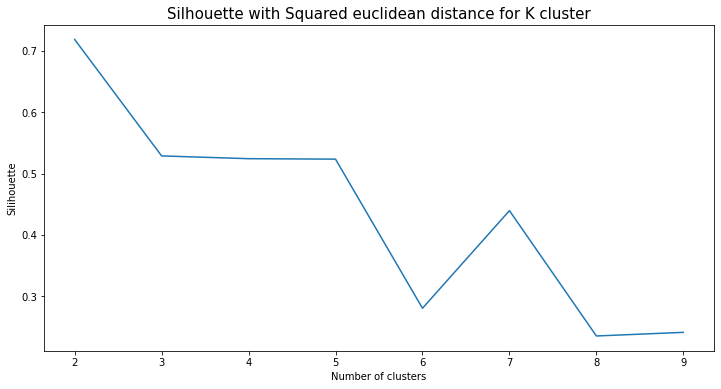

In [32]:
plt.rcParams['figure.figsize'] = (12,6)
sns.lineplot(x = k_params, y = silhouettes, markers = 'a')
plt.title('Silhouette with Squared euclidean distance for K cluster', fontsize = 15)
plt.xlabel('Number of clusters')
plt.ylabel('Silihouette')
plt.show()

## 3. Nhận xét:
- Ta thấy khi k = 2 thì khoảng cách giữa các clusters là xa nhất
- Nhưng gom `300.000` loại thực vật theo `70` khu vực thành `2 cụm` thì có vẻ không mang nhiều ý nghĩa, có thể đơn giản nó tách thành 2 cụm riêng biệt của Mỹ và Canada. 
- Khi `k càng tăng` thì giá trị khoảng cách nhìn chung giảm.

Dưới đây là hình ảnh minh họa với $k \in [2,70]$. Vì thời gian chạy khá lâu nên nhóm em chỉ trích dẫn hình ảnh đưa vào

![title](Data/clusters.png)